In [1]:
import warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DataConversionWarning)
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
warnings.filterwarnings("ignore", category=FutureWarning, module="scipy")

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from typing import List, Tuple, Literal
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
    precision_score,
    accuracy_score,
    recall_score,
    f1_score,
)
from sklearn.model_selection import (
    RepeatedStratifiedKFold,
    train_test_split,
    cross_val_score,
    cross_validate,
    RepeatedKFold,
)

random_state = 1

UTILS

In [3]:
def convert_cell(series: pd.Series):
    converted = pd.to_numeric(series, errors="coerce", downcast="float")
    converted = converted.replace([np.inf, -np.inf], np.nan)
    converted = converted.fillna(np.nan)
    return converted


def clear_data(data: pd.DataFrame, target_feature: str):
    classes = data[target_feature]
    columns = data.columns.drop(target_feature)

    df = data[columns].apply(lambda x: convert_cell(x))

    imputer = SimpleImputer(missing_values=np.nan, strategy="median")
    imputed_df = pd.DataFrame(imputer.fit_transform(df), columns=columns)

    return pd.concat([imputed_df, classes], axis=1)


def remove_outliers_lof(data: pd.DataFrame, target_feature: str) -> pd.DataFrame:
    X = data.drop(columns=[target_feature])
    y = data[target_feature]

    lof = LocalOutlierFactor()
    outlier_labels = lof.fit_predict(X)

    inlier_mask = outlier_labels == 1
    X_clean = X.loc[inlier_mask]
    y_clean = y.loc[inlier_mask]

    return pd.concat([X_clean, y_clean], axis=1)


def split_train_test(
    data: pd.DataFrame, target_feature: str, test_size: float = 0.3
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    train_data, test_data = train_test_split(
        data,
        test_size=test_size,
        random_state=42,
        stratify=data[target_feature],
    )

    return train_data, test_data


def split_features(
    train_data: pd.DataFrame, test_data: pd.DataFrame, target_feature: str
):
    X_train = train_data[[col for col in train_data.columns if col != target_feature]]
    y_train = train_data[target_feature]
    X_test = test_data[[col for col in test_data.columns if col != target_feature]]
    y_test = test_data[target_feature]

    return X_train, y_train, X_test, y_test


def scale_numeric_features(
    X_train: np.ndarray, X_test: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    scaler = StandardScaler()

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled


def apply_pca(
    X_train: np.ndarray, X_test: np.ndarray, components: int = 2
) -> Tuple[np.ndarray, np.ndarray]:
    n_features = X_train.shape[1]
    n_components = min(components, n_features)
    pca = PCA(n_components=n_components)

    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    return X_train_pca, X_test_pca


def predict(
    classifier: DecisionTreeClassifier,
    X_Train: np.ndarray,
    X_test: np.ndarray,
    y_train: np.ndarray,
) -> Tuple[np.ndarray, np.ndarray]:
    classifier = classifier
    classifier.fit(X_Train, y_train.squeeze())

    y_pred_train = classifier.predict(X_Train)
    y_pred_test = classifier.predict(X_test)

    return y_pred_train, y_pred_test


def classification_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="weighted")
    recall = recall_score(y_true, y_pred, average="weighted")
    f_score = f1_score(y_true, y_pred, average="weighted")

    return cm, accuracy, precision, recall, f_score


def Compute_scores(
    data: pd.DataFrame,
    target_feature: str,
    pca_comp=3,
    criterion: Literal["gini", "entropy", "log_loss"] = "gini",
    max_depth=None,
    min_samples_leaf: float = 1,
    ccp_alpha: float = 0,
):
    clean_data = clear_data(data, target_feature)

    clean_data = remove_outliers_lof(clean_data, target_feature)

    train_data, test_data = split_train_test(clean_data, target_feature)

    X_train, y_train, X_test, y_test = split_features(
        train_data, test_data, target_feature
    )

    X_train, X_test = scale_numeric_features(X_train, X_test)

    X_train, X_test = apply_pca(X_train, X_test, pca_comp)

    clf = DecisionTreeClassifier(
        criterion=criterion,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        ccp_alpha=ccp_alpha,
        random_state=random_state,
    )
    y_pred_train, y_pred_test = predict(clf, X_train, X_test, y_train)

    return clf, X_test, y_test, y_pred_test

In [5]:
def full_test(data: pd.DataFrame, target_feature: str, pca_comp: int = 3):
    criterions = ["gini", "entropy", "log_loss"]
    max_depths = [2, 4, 6, 8, None]
    min_samples_leafs = [1, 2, 4, 8]
    ccp_alphas = [0, 0.001, 0.01, 0.05, 0.1]

    results = []
    for criterion in criterions:
        for max_depth in max_depths:
            for min_samples_leaf in min_samples_leafs:
                for ccp_alpha in ccp_alphas:
                    _, _, y_test, y_pred_test = Compute_scores(
                        data,
                        target_feature,
                        pca_comp,
                        criterion,
                        max_depth,
                        min_samples_leaf,
                        ccp_alpha,
                    )
                    _, _, _, _, f_score = classification_metrics(y_test, y_pred_test)
                    result = {
                        "criterion": criterion,
                        "max_depth": max_depth if max_depth is not None else -1,
                        "min_samples_leaf": min_samples_leaf,
                        "cpp_alpha": ccp_alpha,
                        "Score": f_score,
                    }
                    results.append(result)

    results_df = pd.DataFrame(results)

    return results_df


def get_average_for(result: pd.DataFrame, param: str):
    avg_scores = result.groupby(param)["Score"].mean()
    avg_scores_df = avg_scores.reset_index()
    avg_scores_df.columns = [param, "Score"]
    return avg_scores_df


def extract_hyperparams(result: pd.Series):
    criterion = result["criterion"]
    max_depth = result["max_depth"] if result["max_depth"] != -1 else None
    min_samples_leaf = result["min_samples_leaf"]
    ccp_alpha = result["cpp_alpha"]
    return criterion, max_depth, min_samples_leaf, ccp_alpha


def get_best_worst_results(results_df: pd.DataFrame):
    sorted_results = results_df.sort_values(by="Score", ascending=False)
    best_result = sorted_results.iloc[0]
    worst_result = sorted_results.iloc[-1]
    return best_result, worst_result

VISUALIZATION UTILS

In [8]:
def plot_confusion_matrix(
    clf: DecisionTreeClassifier, X_test: np.ndarray, y_test: np.ndarray
):
    y_pred = clf.predict(X_test)
    print(X_test)
    print(y_pred)
    print(classification_report(y_test, y_pred, zero_division=0))
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test.squeeze())
    plt.show()


def visualize_tree(
    clf: DecisionTreeClassifier,
    feature_names: List[str],
    class_names: List[str],
    max_depth=None,
):
    plt.figure(figsize=(20, 10))
    plot_tree(
        clf,
        filled=True,
        feature_names=feature_names,
        class_names=[str(c) for c in class_names],
        proportion=True,
        fontsize=12,
        max_depth=max_depth,
    )
    plt.show()


def full_visualization(
    data: pd.DataFrame,
    target_feature: str,
    pca_comp: int,
    clf,
    X_test,
    y_test,
    y_pred_test,
):
    plot_confusion_matrix(clf, X_test, y_test)
    cm, accuracy, precision, recall, f_score = classification_metrics(
        y_test, y_pred_test
    )
    print(f"Normal F1: {f_score:.4f}")
    depth = None if pca_comp <= 3 else 3
    visualize_tree(
        clf,
        feature_names=[f"PC{i}" for i in range(1, pca_comp + 1)],
        class_names=data[target_feature].unique().tolist(),
        max_depth=depth,
    )


def visualize_best_worst_tree(
    results_df: pd.DataFrame, data: pd.DataFrame, target_feature: str, pca_comp: int
):
    best_result, worst_result = get_best_worst_results(results_df)

    criterion, max_depth, min_samples_leaf, ccp_alpha = extract_hyperparams(best_result)
    clf, X_test, y_test, y_pred_test = Compute_scores(
        data,
        target_feature,
        pca_comp,
        criterion,
        max_depth,
        min_samples_leaf,
        ccp_alpha,
    )
    full_visualization(data, target_feature, pca_comp, clf, X_test, y_test, y_pred_test)

    criterion, max_depth, min_samples_leaf, ccp_alpha = extract_hyperparams(
        worst_result
    )
    clf, X_test, y_test, y_pred_test = Compute_scores(
        data,
        target_feature,
        pca_comp,
        criterion,
        max_depth,
        min_samples_leaf,
        ccp_alpha,
    )
    full_visualization(data, target_feature, pca_comp, clf, X_test, y_test, y_pred_test)


def get_top_n_scores(results_df: pd.DataFrame, n: int):
    sorted_df = results_df.sort_values(by="Score", ascending=False)
    top_n = sorted_df.head(n)
    return top_n


def plot_avg_scores(
    result: pd.DataFrame,
    param: Literal["criterion", "max_depth", "min_samples_leaf", "cpp_alpha"],
):
    avg_scores = get_average_for(result, param)
    plt.figure(figsize=(10, 6))
    plt.plot(avg_scores[param], avg_scores["Score"], marker="o", linestyle="-")
    plt.xlabel(param.capitalize())
    plt.ylabel("Average Score")
    plt.title(f"Average Scores for Different {param.capitalize()} Values")
    plt.show()


def plot_all_avg_scores(result: pd.DataFrame):
    plot_avg_scores(result, "criterion")
    plot_avg_scores(result, "max_depth")
    plot_avg_scores(result, "min_samples_leaf")
    plot_avg_scores(result, "cpp_alpha")

CROSS VALIDATION

In [7]:
def get_data_for_cross_val(
    data: pd.DataFrame,
    target_feature: str,
    pca_comp: int = 3,
    criterion: Literal["gini", "entropy", "log_loss"] = "gini",
    max_depth=None,
    min_samples_leaf: float = 1,
    ccp_alpha: float = 0,
    class_weight=None,
):
    clean_data = clear_data(data, target_feature)
    no_outliers_data = remove_outliers_lof(clean_data, target_feature)
    X, y, dummy, _ = split_features(no_outliers_data, no_outliers_data, target_feature)
    X_scaled, _ = scale_numeric_features(X, dummy)
    X, _ = apply_pca(X_scaled, dummy, pca_comp)

    clf = DecisionTreeClassifier(
        criterion=criterion,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        ccp_alpha=ccp_alpha,
        random_state=random_state,
        class_weight=class_weight,
    )

    return clf, X, y


def cross_validation_scores(
    data: pd.DataFrame,
    target_feature: str,
    pca_comp=3,
    criterion: Literal["gini", "entropy", "log_loss"] = "gini",
    max_depth=None,
    min_samples_leaf: float = 1,
    ccp_alpha: float = 0,
    stratify: bool = False,
    print_result: bool = False,
    class_weight=None,
):
    clf, X, y = get_data_for_cross_val(
        data,
        target_feature,
        pca_comp,
        criterion,
        max_depth,
        min_samples_leaf,
        ccp_alpha,
        class_weight,
    )

    if stratify:
        kfold = RepeatedStratifiedKFold(n_splits=4, n_repeats=1)
    else:
        kfold = RepeatedKFold(n_splits=4, n_repeats=1)
    cv_scores = cross_val_score(clf, X, y, cv=kfold, scoring="f1_weighted")
    mean_score = cv_scores.mean()

    if print_result:
        strat = "" if stratify else "non_"
        print(f"{strat}stratify cross-validation: F1-score = {mean_score:.4f}")

    return mean_score


def full_test_cross_val(data: pd.DataFrame, target_feature: str, pca_comp: int = 3):
    criterions = ["gini", "entropy", "log_loss"]
    max_depths = [2, 4, 6, 8, None]
    min_samples_leafs = [1, 2, 4, 8]
    ccp_alphas = [0, 0.001, 0.01, 0.05, 0.1]

    results = []
    for criterion in criterions:
        for max_depth in max_depths:
            for min_samples_leaf in min_samples_leafs:
                for ccp_alpha in ccp_alphas:
                    for stratify in [False, True]:
                        score = cross_validation_scores(
                            data,
                            target_feature,
                            pca_comp,
                            criterion,
                            max_depth,
                            min_samples_leaf,
                            ccp_alpha,
                            stratify,
                        )
                        result = {
                            "criterion": criterion,
                            "max_depth": max_depth if max_depth is not None else -1,
                            "min_samples_leaf": min_samples_leaf,
                            "cpp_alpha": ccp_alpha,
                            "stratify": str(stratify),
                            "Score": score,
                        }
                        results.append(result)

    results_df = pd.DataFrame(results)

    return results_df


def plot_cross_average(result: pd.DataFrame):
    avg_scores = get_average_for(result, "stratify")
    plt.figure(figsize=(10, 6))
    min_score = avg_scores["Score"].min()
    max_score = avg_scores["Score"].max()

    norm = abs(min_score - max_score)

    plt.ylim(min_score - norm, max_score + norm)
    plt.bar(avg_scores["stratify"], avg_scores["Score"])
    plt.xlabel("stratify".capitalize())
    plt.ylabel("Average Score")
    plt.title(f"Average Scores for Different Stratify Values")
    plt.show()

CLASS WEIGHT

In [8]:
def full_test_class_Weight(data: pd.DataFrame, target_feature: str, pca_comp: int = 3):
    criterions = ["gini", "entropy", "log_loss"]
    max_depths = [2, 4, 6, 8, None]
    min_samples_leafs = [1, 2, 4, 8]
    ccp_alphas = [0, 0.001, 0.01, 0.05, 0.1]
    class_weights = [
        None,
        {"Iris-setosa": 2, "Iris-versicolor": 1, "Iris-virginica": 1},
        {"Iris-setosa": 1, "Iris-versicolor": 2, "Iris-virginica": 1},
        {"Iris-setosa": 1, "Iris-versicolor": 1, "Iris-virginica": 2},
    ]
    results = []
    for criterion in criterions:
        for max_depth in max_depths:
            for min_samples_leaf in min_samples_leafs:
                for ccp_alpha in ccp_alphas:
                    for class_weight in class_weights:
                        score = cross_validation_scores(
                            data,
                            target_feature,
                            pca_comp,
                            criterion,
                            max_depth,
                            min_samples_leaf,
                            ccp_alpha,
                            True,
                            False,
                            class_weight,
                        )
                        result = {
                            "criterion": criterion,
                            "max_depth": max_depth if max_depth is not None else -1,
                            "min_samples_leaf": min_samples_leaf,
                            "cpp_alpha": ccp_alpha,
                            "class_weight": str(class_weight),
                            "Score": score,
                        }
                        results.append(result)

    results_df = pd.DataFrame(results)

    return results_df


def plot_class_weight(result: pd.DataFrame):
    avg_scores = get_average_for(result, "class_weight")
    plt.figure(figsize=(20, 6))
    min_score = avg_scores["Score"].min()
    max_score = avg_scores["Score"].max()

    norm = abs(min_score - max_score)

    plt.ylim(min_score - norm, max_score + norm)
    ax = plt.gca()
    ax.set_xticklabels(avg_scores["class_weight"], fontsize=6)
    ax.tick_params(axis="x", which="major", pad=10)
    plt.bar(avg_scores["class_weight"], avg_scores["Score"])
    plt.xlabel("class_weight".capitalize(), fontsize=12)
    plt.ylabel("Average Score")
    plt.title(f"Average Scores for Different Class_weight Values")
    plt.show()

IRIS

In [4]:
class Iris:
    sepal_length = "sepal-length"
    sepal_width = "sepal-width"
    petal_length = "petal-length"
    petal_width = "petal-width"
    target_feature = "class"

    def get_dataFrame() -> pd.DataFrame:
        data = pd.read_csv(
            "iris.data",
            names=[
                Iris.sepal_length,
                Iris.sepal_width,
                Iris.petal_length,
                Iris.petal_width,
                Iris.target_feature,
            ],
        )

        return data

[[ 2.11566     0.6229487 ]
 [ 0.7627353   0.07945243]
 [-2.2815478  -2.04695   ]
 [ 0.47401583  1.7515169 ]
 [-1.8680395  -0.17299429]
 [ 0.3610797   0.08547953]
 [-2.3591547  -0.5440251 ]
 [-2.095752   -0.7727993 ]
 [ 1.5825396  -1.2938514 ]
 [-2.3212929   0.28746718]
 [ 1.3741417  -1.2290326 ]
 [-2.2285557  -1.2941078 ]
 [-2.436944   -1.2742494 ]
 [ 2.4051054  -0.5803584 ]
 [ 1.9574462  -0.88402355]
 [-0.45793796  1.8666174 ]
 [ 1.3872029  -0.5837609 ]
 [-2.294525   -0.21830799]
 [-2.294506   -0.30822855]
 [ 0.21879132  1.2786498 ]
 [ 1.5254649  -0.4059741 ]
 [-2.4223807   0.29257384]
 [ 0.42299443  0.51551753]
 [ 0.4208461  -1.0256363 ]
 [ 0.3907824   1.5286926 ]
 [ 0.92779356 -0.3834162 ]
 [ 1.4181833  -0.48114288]
 [ 1.1480113   1.35779   ]
 [ 1.9511547  -0.7235348 ]
 [-2.237483   -1.1801428 ]
 [-2.4828632   0.8899716 ]
 [-2.227105   -0.35659325]
 [ 0.99244225 -0.14761958]
 [ 1.9272     -0.5628446 ]
 [ 0.226277    0.18220894]
 [ 0.76130337 -0.947983  ]
 [ 0.75856936 -0.75374216]
 

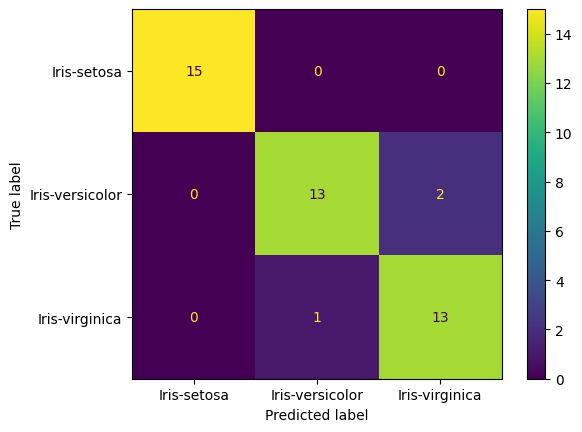

Normal F1: 0.9318


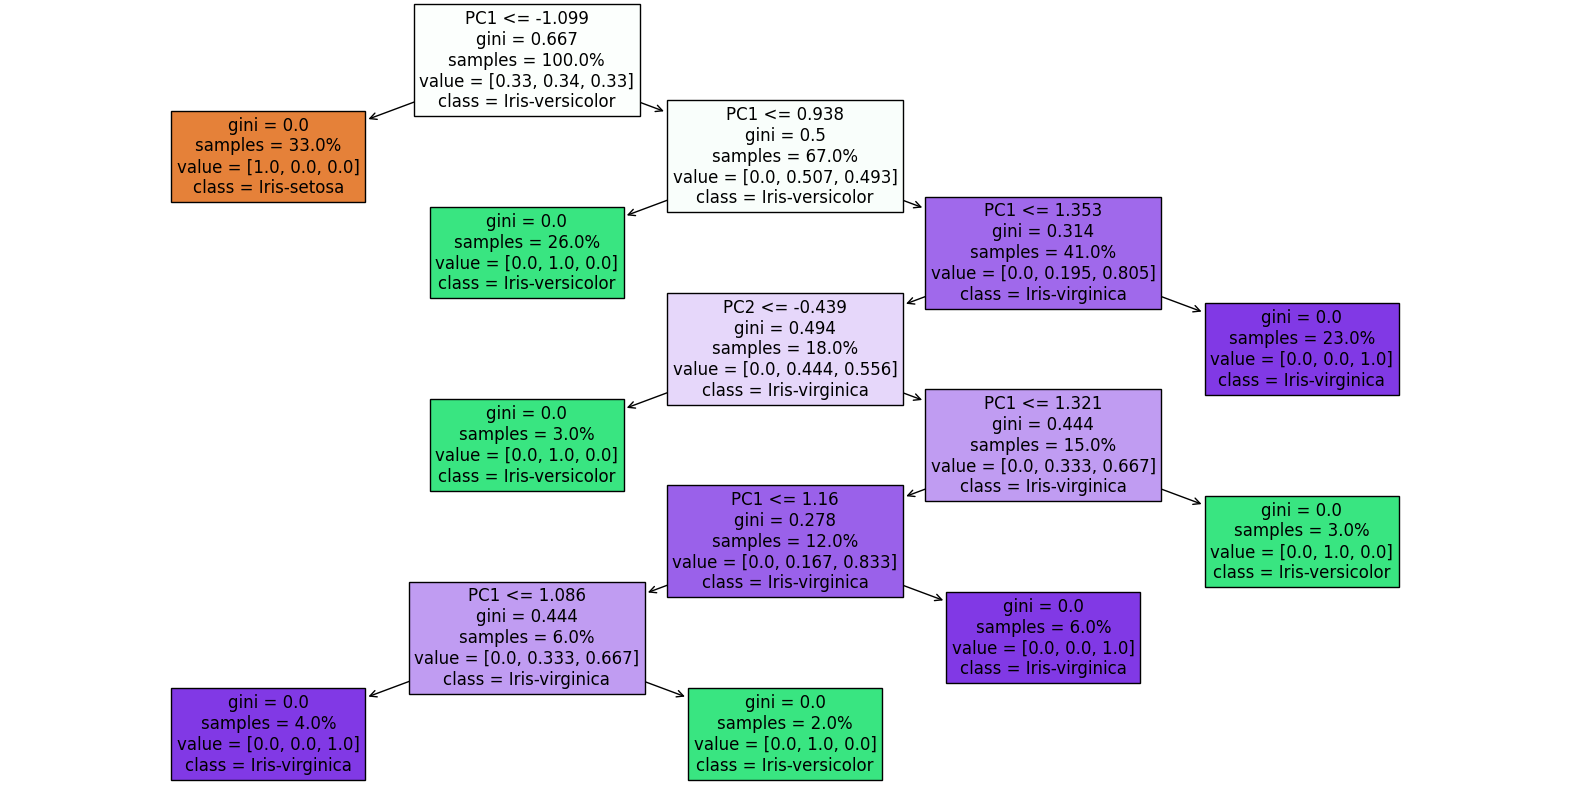

In [9]:
iris_data = Iris.get_dataFrame()
clf, X_test, y_test, y_pred_test = Compute_scores(
    iris_data, Iris.target_feature, pca_comp=2
)

plot_confusion_matrix(clf, X_test, y_test)
cm, accuracy, precision, recall, f_score = classification_metrics(y_test, y_pred_test)
print(f"Normal F1: {f_score:.4f}")
visualize_tree(
    clf,
    feature_names=["PC1", "PC2"],
    class_names=iris_data[Iris.target_feature].unique().tolist(),
)

Strojenie hiperparametrów

In [11]:
result = full_test(iris_data, Iris.target_feature, pca_comp=2)

    criterion  max_depth  min_samples_leaf  cpp_alpha     Score
230  log_loss          4                 4      0.000  0.931818
256  log_loss          6                 8      0.001  0.931818
56       gini          6                 8      0.001  0.931818
55       gini          6                 8      0.000  0.931818
82       gini         -1                 1      0.010  0.931818
187   entropy         -1                 2      0.010  0.931818
186   entropy         -1                 2      0.001  0.931818
185   entropy         -1                 2      0.000  0.931818
255  log_loss          6                 8      0.000  0.931818
257  log_loss          6                 8      0.010  0.931818
266  log_loss          8                 2      0.001  0.931818
235  log_loss          4                 8      0.000  0.931818
196   entropy         -1                 8      0.001  0.931818
260  log_loss          8                 1      0.000  0.931818
261  log_loss          8                

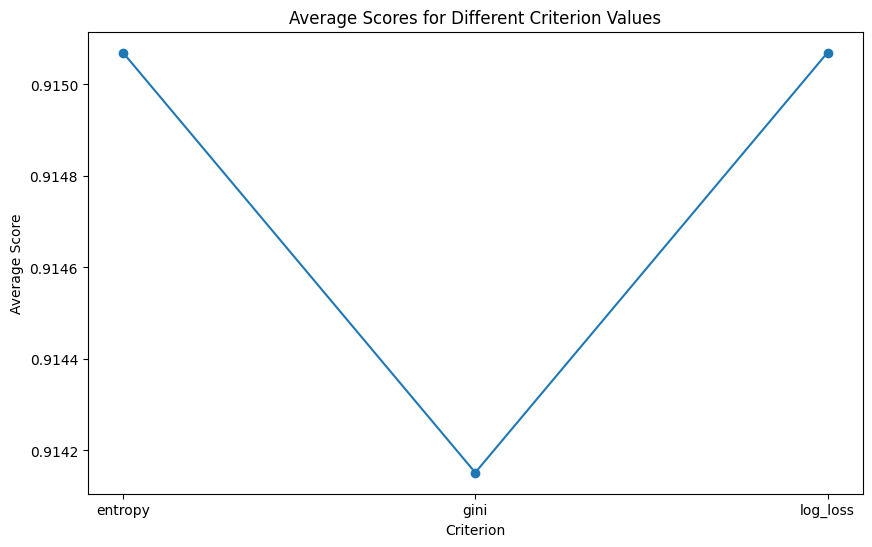

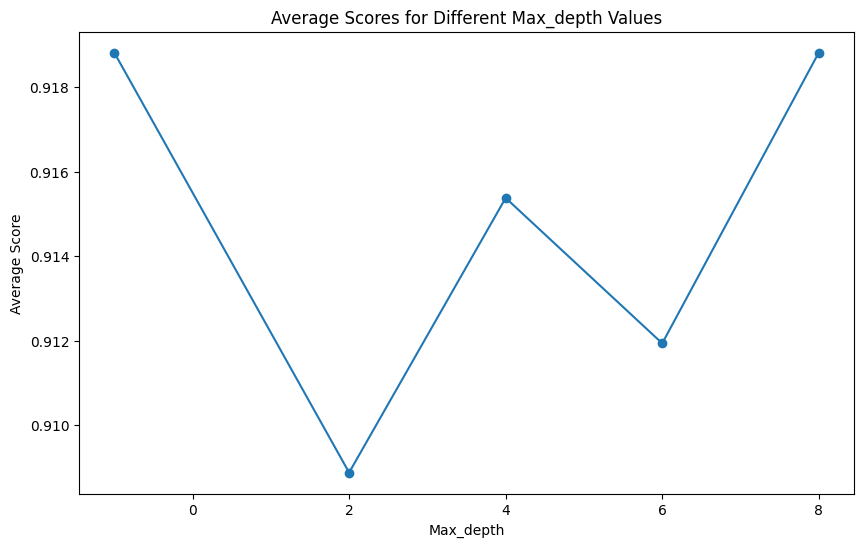

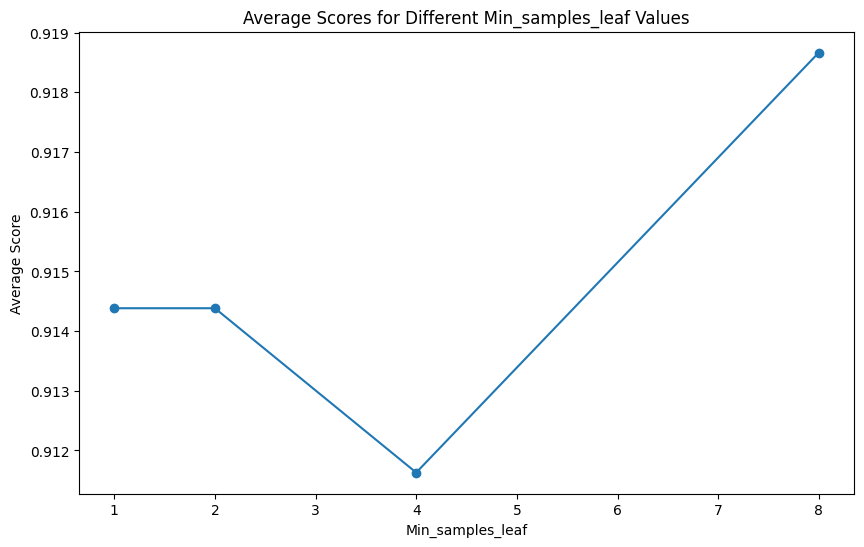

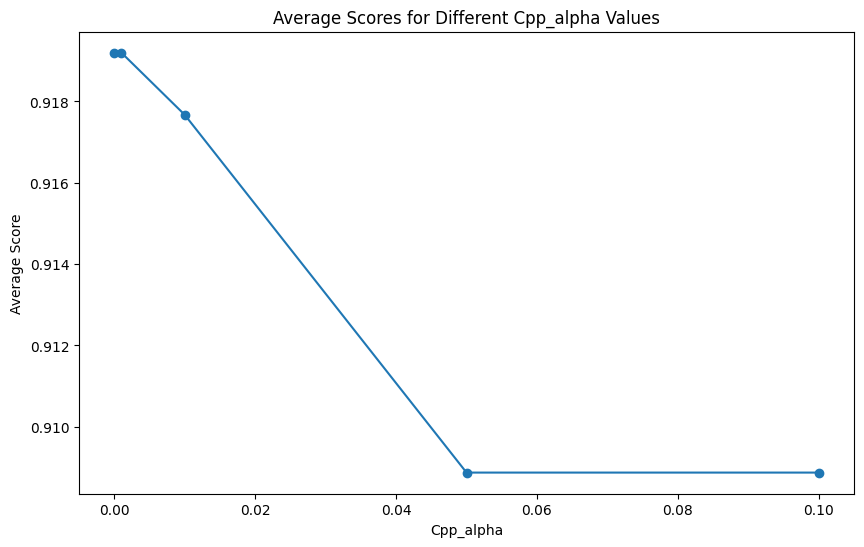

In [12]:
print(get_top_n_scores(result, 15))

plot_all_avg_scores(result)

NAJLEPSZY WYNIK A NAJGORSZY WYNIK

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        15
Iris-versicolor       0.93      0.87      0.90        15
 Iris-virginica       0.87      0.93      0.90        14

       accuracy                           0.93        44
      macro avg       0.93      0.93      0.93        44
   weighted avg       0.93      0.93      0.93        44



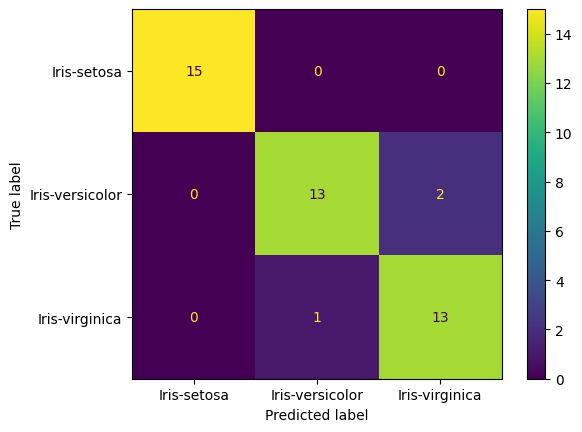

Normal F1: 0.9318


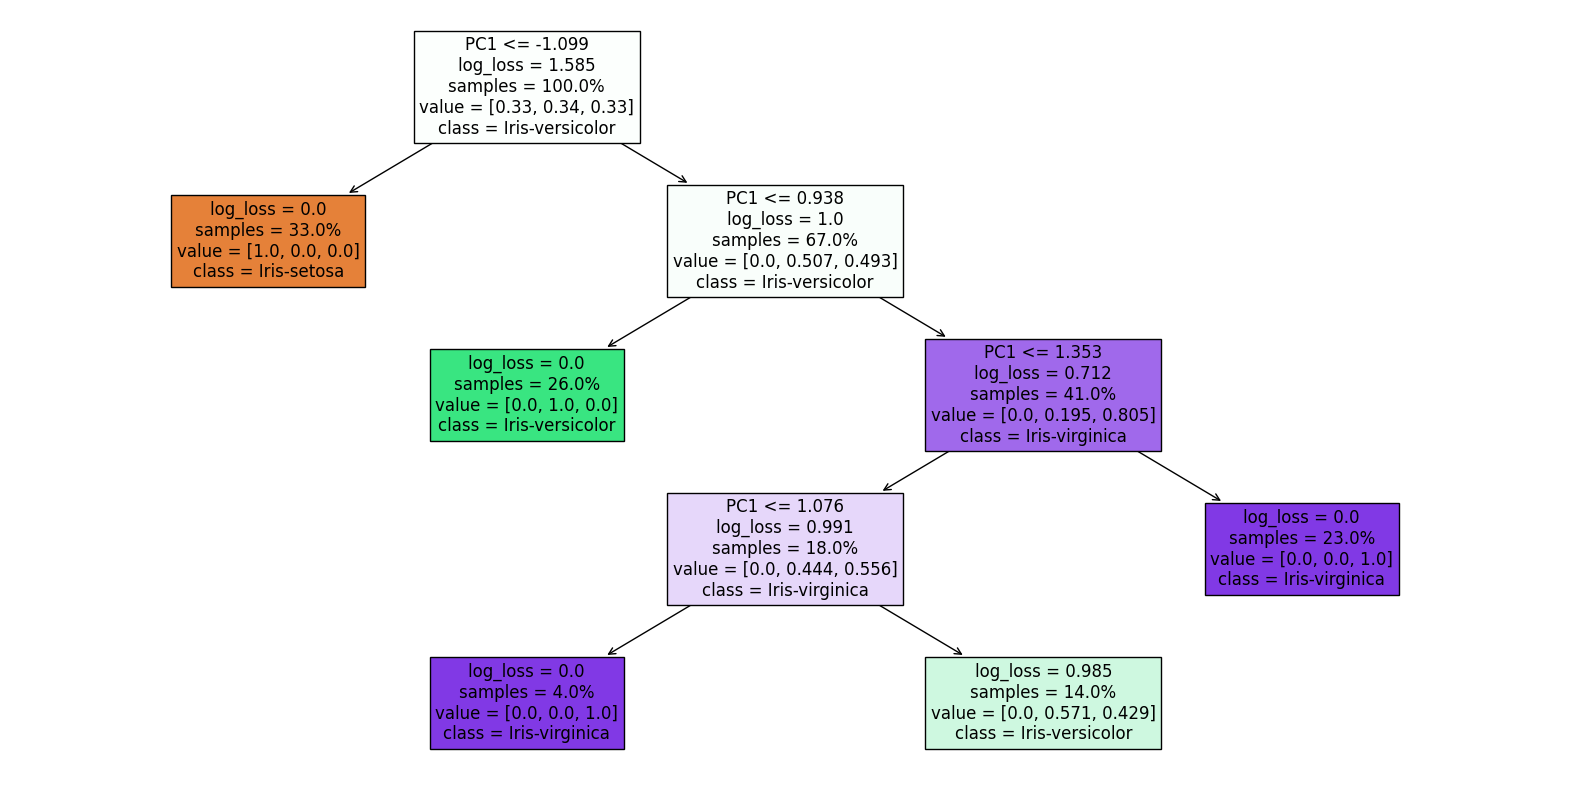

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        15
Iris-versicolor       0.92      0.80      0.86        15
 Iris-virginica       0.81      0.93      0.87        14

       accuracy                           0.91        44
      macro avg       0.91      0.91      0.91        44
   weighted avg       0.91      0.91      0.91        44



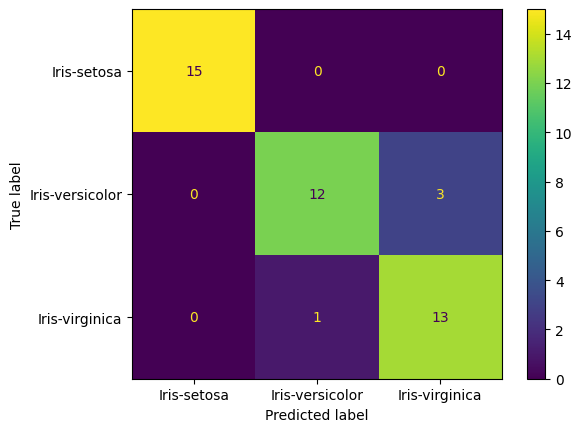

Normal F1: 0.9089


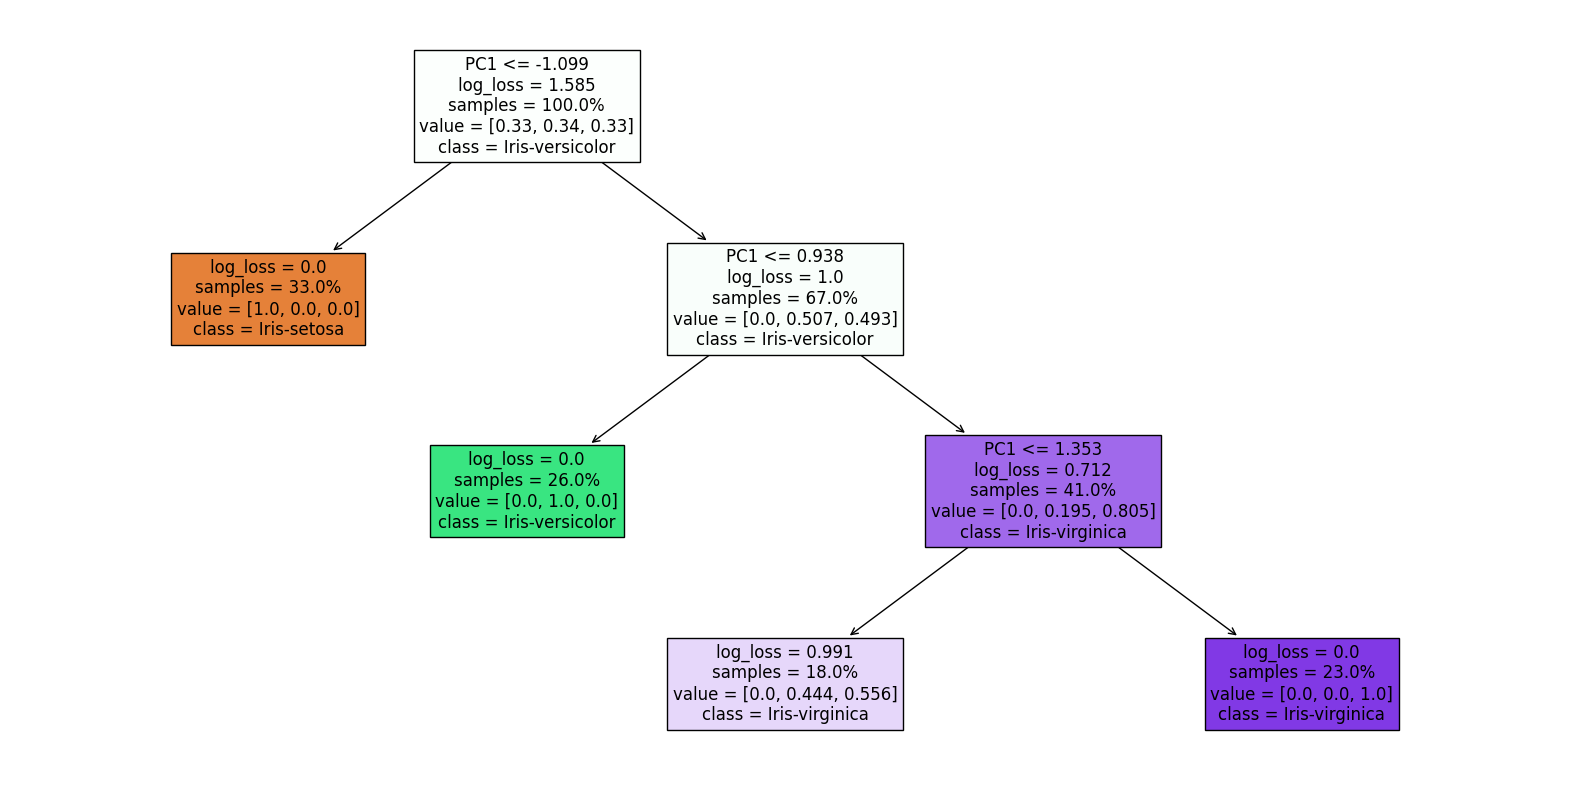

In [13]:
visualize_best_worst_tree(result, iris_data, Iris.target_feature, pca_comp=2)

IRIS CROSSVALIDATION

In [14]:
result = full_test_cross_val(iris_data, Iris.target_feature, pca_comp=2)

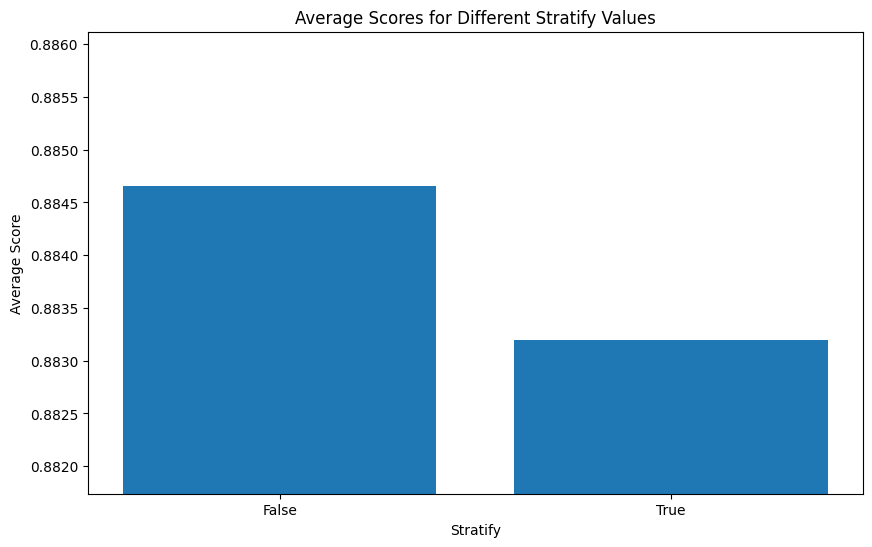

In [15]:
plot_cross_average(result)

CLASS WEIGHT

In [16]:
result = full_test_class_Weight(iris_data, Iris.target_feature, pca_comp=2)

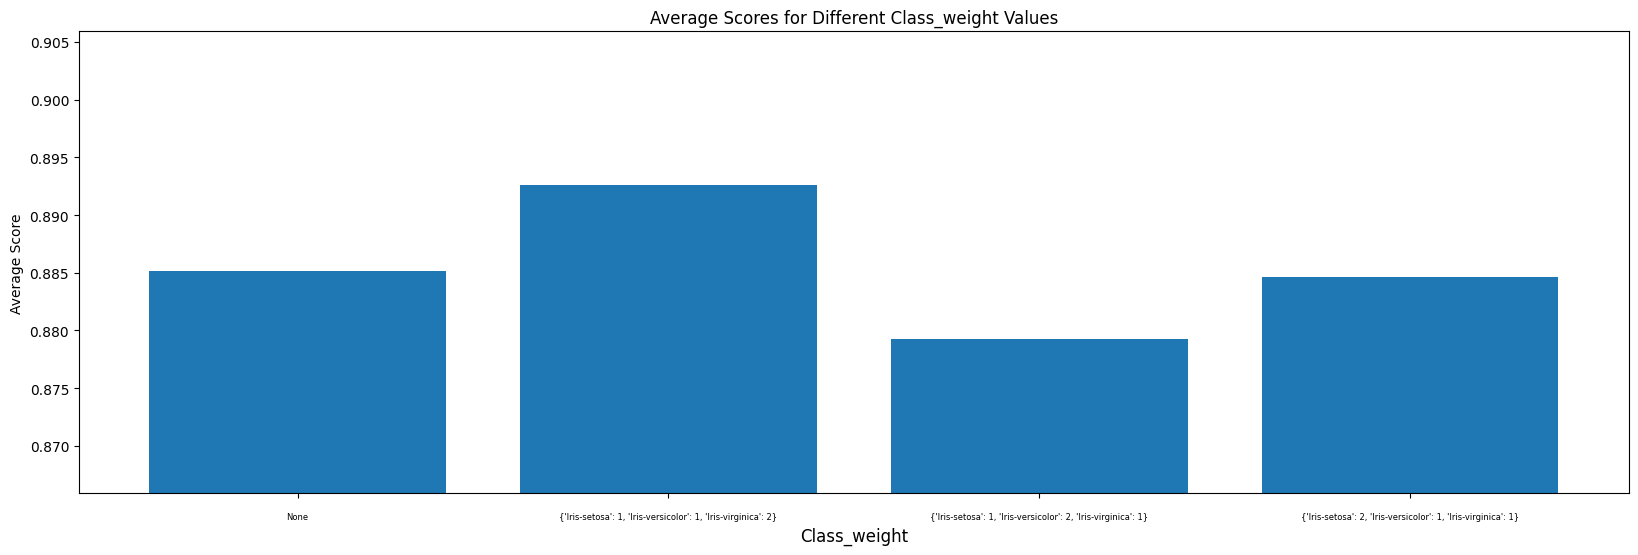

In [17]:
plot_class_weight(result)

PCB

In [18]:
class Pcb:
    target_feature = "class (0,1)"

    def get_dataFrame(year: int = 1) -> pd.DataFrame:
        data = pd.read_csv(
            f"{year}year.csv",
            names=[
                "net profit / total assets",
                "total liabilities / total assets",
                "working capital / total assets",
                "current assets / short-term liabilitiesl",
                "[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365",
                "retained earnings / total assets",
                "EBIT / total assets",
                "book value of equity / total liabilities",
                "sales / total assets",
                "equity / total assets",
                "(gross profit + extraordinary items + financial expenses) / total assets",
                "gross profit / short-term liabilities",
                "(gross profit + depreciation) / sales",
                "(gross profit + interest) / total assets",
                "(total liabilities * 365) / (gross profit + depreciation)",
                "(gross profit + depreciation) / total liabilities",
                "total assets / total liabilities",
                "gross profit / total assets",
                "gross profit / sales",
                "(inventory * 365) / sales",
                "sales (n) / sales (n-1)",
                "profit on operating activities / total assets",
                "net profit / sales",
                "gross profit (in 3 years) / total assets",
                "(equity - share capital) / total assets",
                "(net profit + depreciation) / total liabilities",
                "profit on operating activities / financial expenses",
                "working capital / fixed assets",
                "logarithm of total assets",
                "(total liabilities - cash) / sales",
                "(gross profit + interest) / sales",
                "(current liabilities * 365) / cost of products sold",
                "operating expenses / short-term liabilities",
                "operating expenses / total liabilities",
                "profit on sales / total assets",
                "total sales / total assets",
                "(current assets - inventories) / long-term liabilities",
                "constant capital / total assets",
                "profit on sales / sales",
                "(current assets - inventory - receivables) / short-term liabilities",
                "total liabilities / ((profit on operating activities + depreciation) * (12/365))",
                "profit on operating activities / sales",
                "rotation receivables + inventory turnover in days",
                "(receivables * 365) / sales",
                "net profit / inventory",
                "(current assets - inventory) / short-term liabilities",
                "(inventory * 365) / cost of products sold",
                "EBITDA (profit on operating activities - depreciation) / total assets",
                "EBITDA (profit on operating activities - depreciation) / sales",
                "current assets / total liabilities",
                "short-term liabilities / total assets",
                "(short-term liabilities * 365) / cost of products sold)",
                "equity / fixed assets",
                "constant capital / fixed assets",
                "working capita",
                "(sales - cost of products sold) / sales",
                "(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation)",
                "total costs /total sales",
                "long-term liabilities / equity",
                "sales / inventory",
                "sales / receivables",
                "(short-term liabilities *365) / sales",
                "sales / short-term liabilities",
                "sales / fixed assets",
                Pcb.target_feature,
            ],
        )

        return data

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1781
           1       0.05      0.04      0.04        71

    accuracy                           0.93      1852
   macro avg       0.50      0.50      0.50      1852
weighted avg       0.93      0.93      0.93      1852



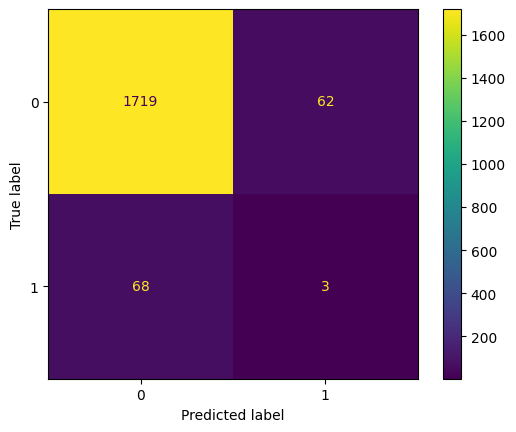

Normal F1: 0.9283


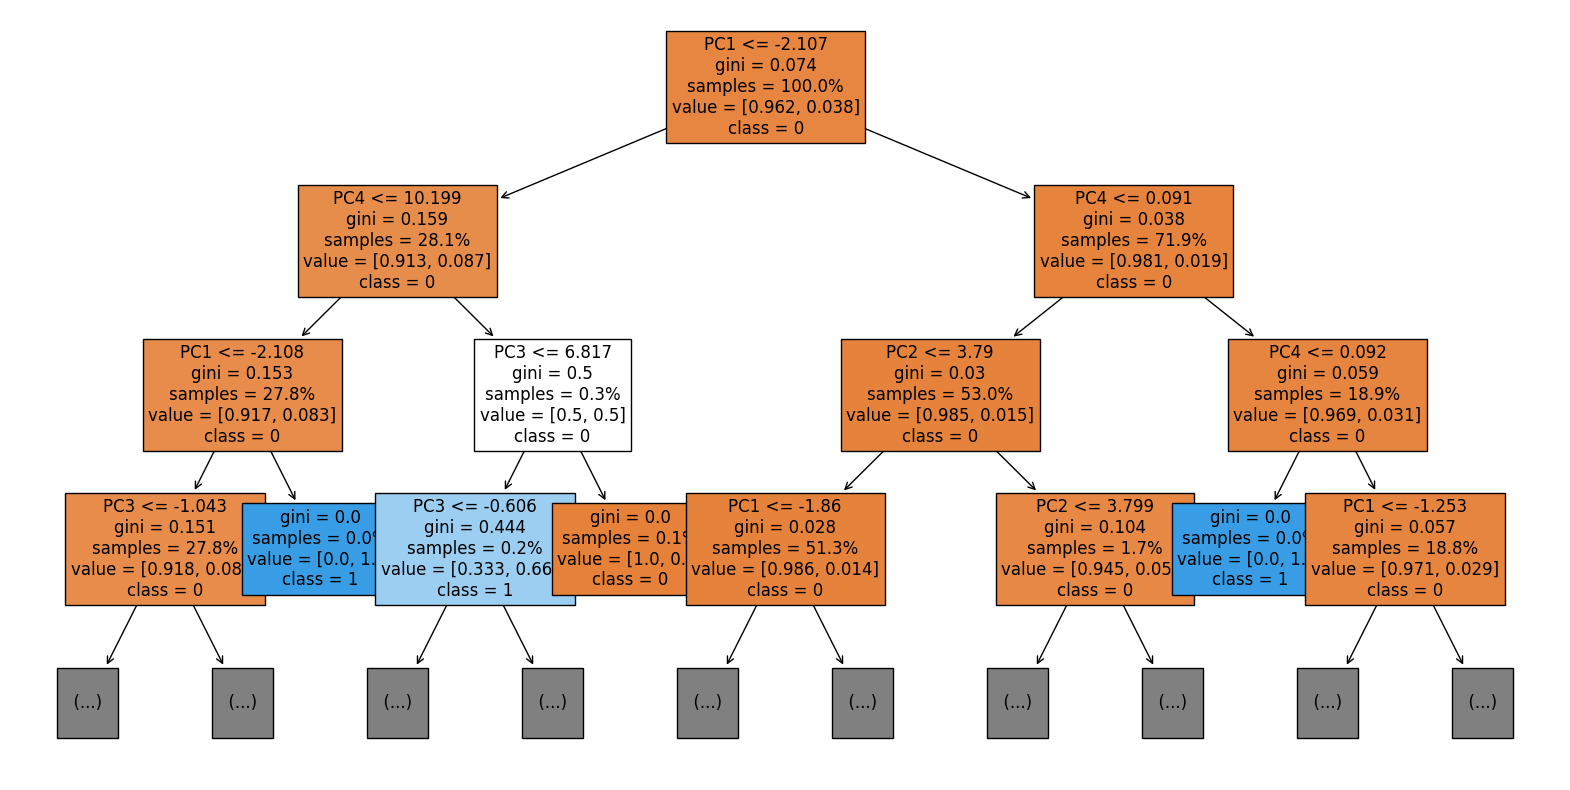

In [19]:
pcb_data = Pcb.get_dataFrame()
clf, X_test, y_test, y_pred_test = Compute_scores(
    pcb_data, Pcb.target_feature, pca_comp=4
)

plot_confusion_matrix(clf, X_test, y_test)
cm, accuracy, precision, recall, f_score = classification_metrics(y_test, y_pred_test)
print(f"Normal F1: {f_score:.4f}")
visualize_tree(
    clf,
    feature_names=["PC1", "PC2", "PC3", "PC4"],
    class_names=pcb_data[Pcb.target_feature].unique().tolist(),
    max_depth=3,
)

In [20]:
result = full_test(pcb_data, Pcb.target_feature, pca_comp=4)

    criterion  max_depth  min_samples_leaf  cpp_alpha     Score
95       gini         -1                 8      0.000  0.943625
175   entropy          8                 8      0.000  0.943413
275  log_loss          8                 8      0.000  0.943413
0        gini          2                 1      0.000  0.942869
193   entropy         -1                 4      0.050  0.942869
176   entropy          8                 8      0.001  0.942869
177   entropy          8                 8      0.010  0.942869
178   entropy          8                 8      0.050  0.942869
179   entropy          8                 8      0.100  0.942869
182   entropy         -1                 1      0.010  0.942869
183   entropy         -1                 1      0.050  0.942869
184   entropy         -1                 1      0.100  0.942869
187   entropy         -1                 2      0.010  0.942869
188   entropy         -1                 2      0.050  0.942869
189   entropy         -1                

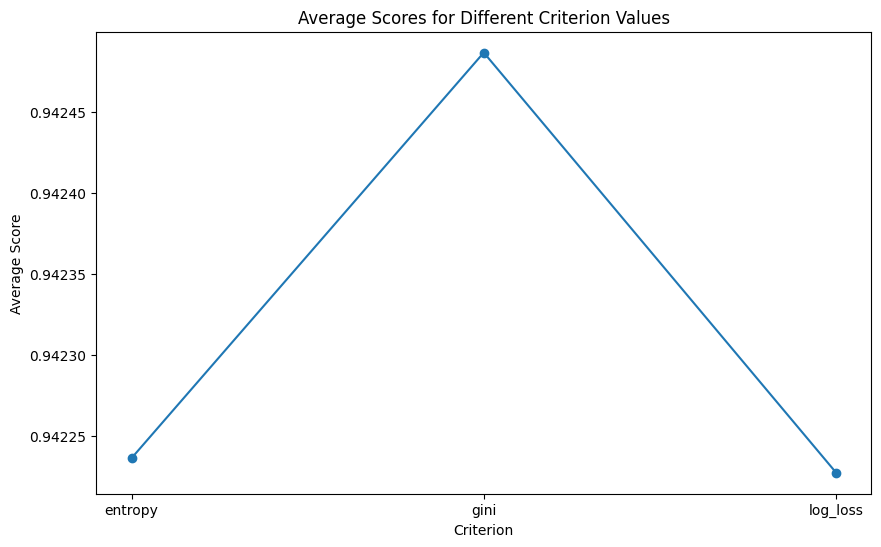

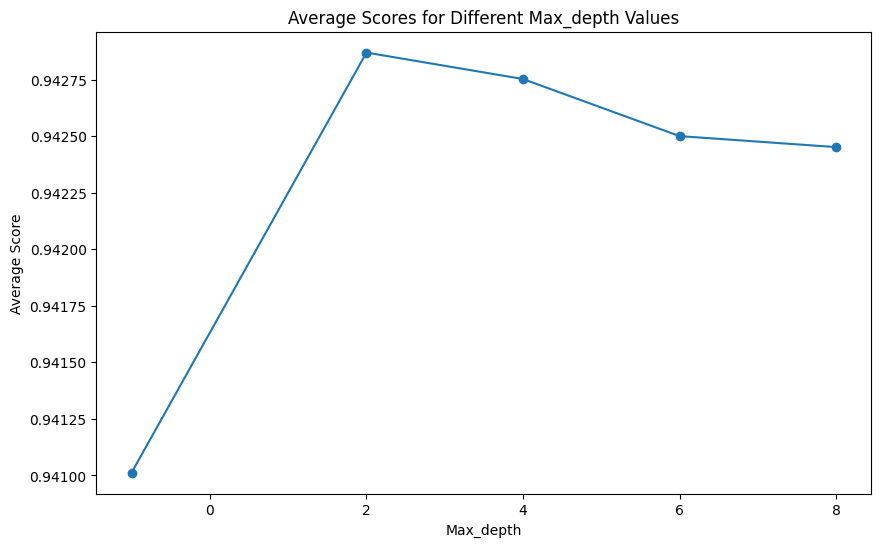

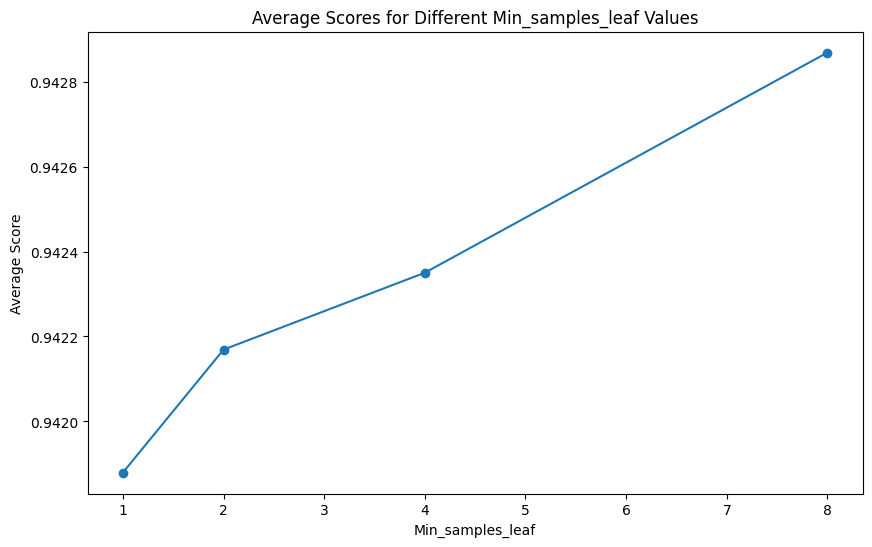

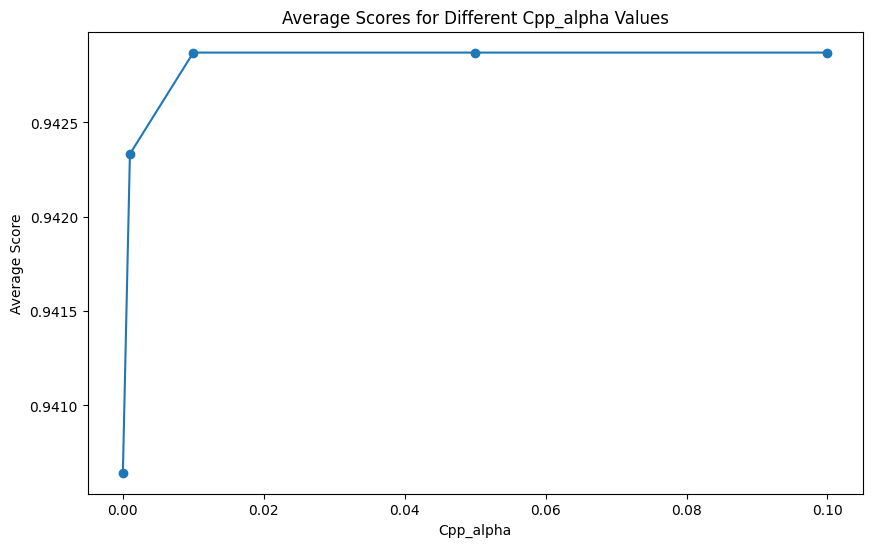

In [21]:
print(get_top_n_scores(result, 15))

plot_all_avg_scores(result)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1781
           1       0.33      0.01      0.03        71

    accuracy                           0.96      1852
   macro avg       0.65      0.51      0.50      1852
weighted avg       0.94      0.96      0.94      1852



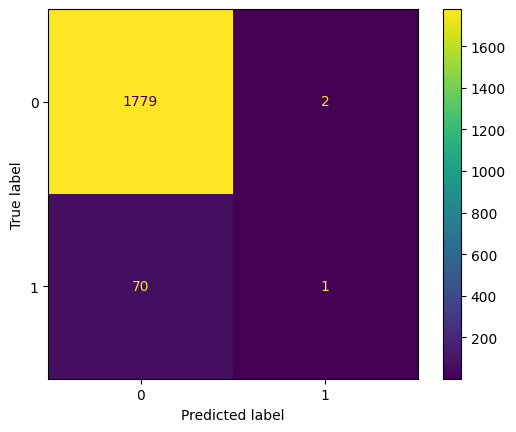

Normal F1: 0.9436


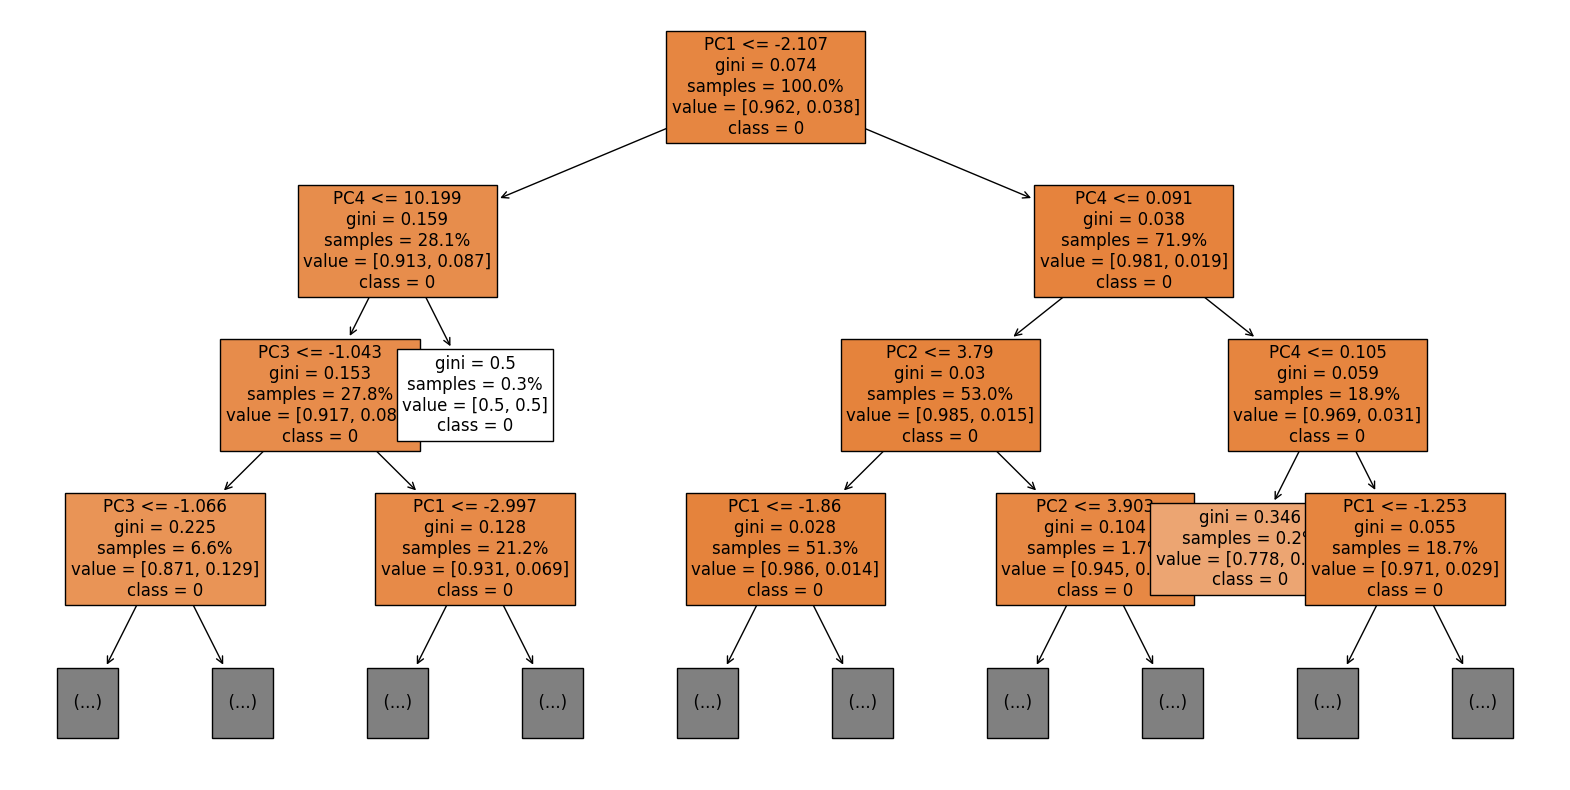

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1781
           1       0.05      0.04      0.04        71

    accuracy                           0.93      1852
   macro avg       0.50      0.50      0.50      1852
weighted avg       0.93      0.93      0.93      1852



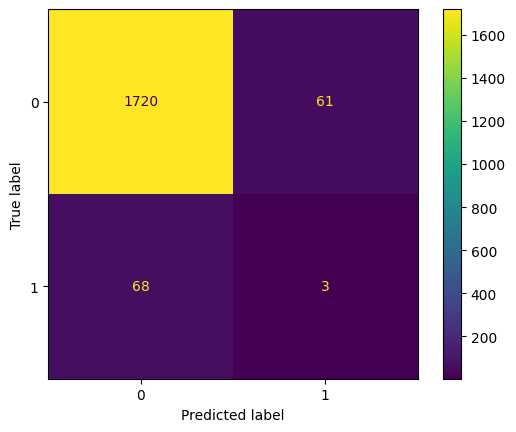

Normal F1: 0.9286


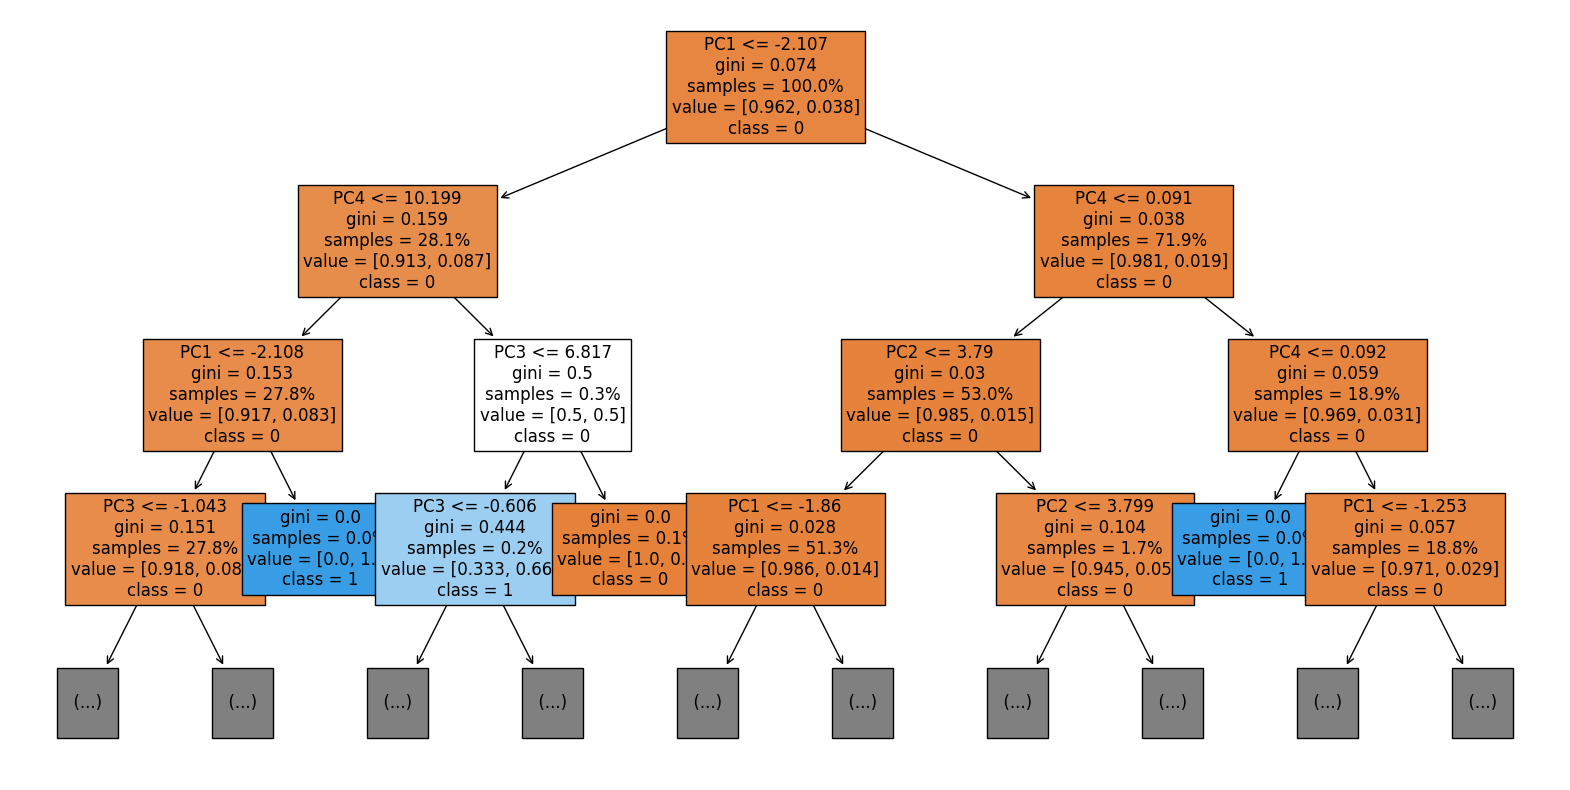

In [22]:
visualize_best_worst_tree(result, pcb_data, Pcb.target_feature, pca_comp=4)

PCB CROSSVALIDATION

In [23]:
result = full_test_cross_val(pcb_data, Pcb.target_feature, pca_comp=4)

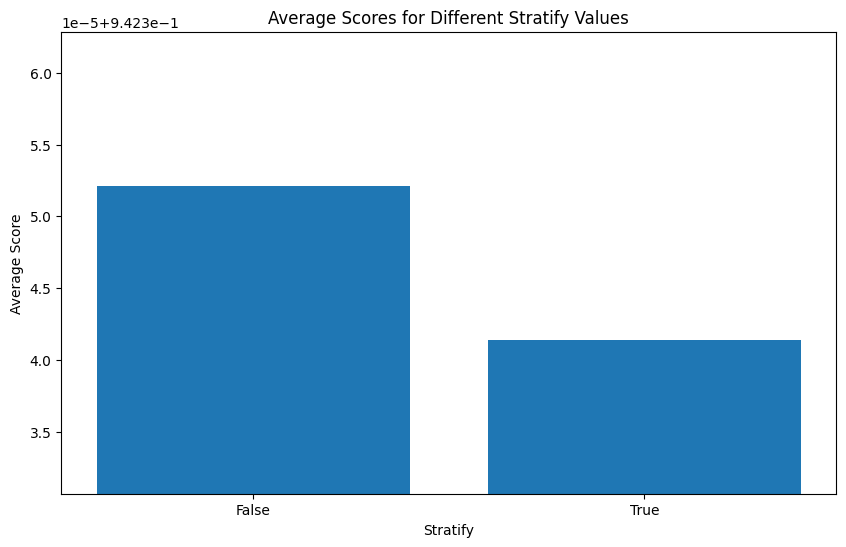

In [24]:
plot_cross_average(result)